## Preprocess data in successive stages
- [0. Select samples and down-sample cells](#downsample_cells)
- [1. Arcsinh normalization](#arcsinh_norm)
- [2. Set an upper ceiling value on CyTOF intensity](#upper_ceiling)
- [3. Initial clustering to remove doublets](#clustering1)
- [3. Filter doublets, RBCs, and T-cell cluster from MultiplexGroup 1 with low CD4/CD8 artifact](#filter_doublets_RBC_Tlow)
- [4. COMBAT Batch correction per cell-type](#batch_per_celltype)
- [5. Optional repleat clustering after COMBAT but before cNMF](#clustering2)
- [6. Run cNMF and regress out platelet / fixation artifact](#cNMF)
- [7. Run clustering on the COMBAT / cNMF corrected data](#clustering3)
- [8. Run subclustering on B-cells, myeloid cells, and T/NK cells](#Subclustering)
     - [8a. B cells](#Subclustering/Subcluster.Cytof.B.ipynb)
     - [8b. Myeloid cells](#Subclustering/Subcluster.Cytof.Myeloid.ipynb)
     - [8c. T/NK cells](#Subclustering/Subcluster.Cytof.TNK.ipynb)
- [9. Final clustering after filtering doublets found during subclustering](#clustering4)
- [10. Make figures](#figures)
     - [10a. Marker plot](#markerplot)
     - [10b. UMAP DPI](#umap_dpi)
     - [10c. UMAP cell type](#umap_celltype)
     - [10d. UMAP batch](#umap_batch)

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
%autosave 60

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scanpy as sc
import seaborn as sns
import glob
import os
import palettable
from harmony import harmonize

from joblib import parallel_backend

import sys
sys.path.append('../../Code')
from utils import save_adata, read_adata, pca_cytof
sys.path.append('../../Code/cNMF')
from cnmf import save_df_to_npz

import matplotlib.gridspec as gridspec


sc.settings.set_figure_params(dpi=80, vector_friendly=False, ipython_format='png')
gcs = False

Autosaving every 60 seconds


/opt/miniconda3/envs/seqwell/lib/python3.7/site-packages/anndata/_core/anndata.py:21: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex
/opt/miniconda3/envs/seqwell/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.decomposition.nmf module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.decomposition. Anything that cannot be imported from sklearn.decomposition is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
adir = '../../../data/Emory/'
project_name = 'Emory_EVD_280K'
results_dir = '../../../../results'


## Load in the unprocessed data from all of the samples together

In [21]:
baseline_raw_file = os.path.join(adir, "Emory_EVD_Raw_8M.h5ad")
baseline_raw_file

'../../../data/Emory/Emory_EVD_Raw_8M.h5ad'

In [22]:
adata = read_adata(baseline_raw_file, ext='.h5ad', gcs=True)

In [23]:
adata.obs.columns

Index(['full_sample', 'sid', 'day', 'collectionday', 'eventNumber', 'Time',
       'Event_length', 'BC1', 'Rh103Di', 'BC2', 'BC3', 'BC4', 'BC5', 'BC6',
       'Sn120Di', 'I127Di', 'Xe131Di', 'Cs133Di', 'Ba138Di', 'DNA1', 'DNA2',
       'Viability1', 'Viability2', 'Viability3', 'Viability4', 'Pb206Di',
       'Pb208Di'],
      dtype='object')

In [24]:
adata.obs['day_fix'] = adata.obs['day'].astype(str)
ind = adata.obs['day'].isin(['March6', 'April9', 'April3', 'May', 'Feb'])
adata.obs.loc[ind, 'day_fix'] = 'Control'
pd.crosstab([adata.obs['sid'], adata.obs['day_fix']], adata.obs['collectionday'])

collectionday    10FEB2018  12SEP2018  24MAY2018
sid     day_fix                                 
C145    Control      61344          0      37253
C396    Control          0    1720872          0
C480    Control          0    1895250          0
C482    Control          0    1720721          0
C928    Control      38254          0      27482
EVD2    D12              0          0      77538
        D19              0          0     128629
EVD5    D17              0          0     100087
        D25              0          0     134239
EVD9    D14          45522          0          0
        D20         170928          0          0
        D28         255546          0          0
        D6           20505          0          0
EVD15   D2               0          0      20871
        D7               0          0     114769
YFW 851 D14              0     818206          0

In [25]:
adata = adata[adata.obs['collectionday']!='12SEP2018',:]

In [26]:
adata

View of AnnData object with n_obs × n_vars = 1232967 × 42 
    obs: 'full_sample', 'sid', 'day', 'collectionday', 'eventNumber', 'Time', 'Event_length', 'BC1', 'Rh103Di', 'BC2', 'BC3', 'BC4', 'BC5', 'BC6', 'Sn120Di', 'I127Di', 'Xe131Di', 'Cs133Di', 'Ba138Di', 'DNA1', 'DNA2', 'Viability1', 'Viability2', 'Viability3', 'Viability4', 'Pb206Di', 'Pb208Di', 'day_fix'
    var: 'Channel', 'gene_symbol', 'Use'

In [28]:
baseline_raw_file = os.path.join(adir, "Emory_EVD_Raw_NoSept12_1M.h5ad")
baseline_raw_file

'../../../data/Emory/Emory_EVD_Raw_NoSept12_1M.h5ad'

In [29]:
save_adata(adata, baseline_raw_file, gcs=False)

/opt/miniconda3/envs/seqwell/lib/python3.7/site-packages/anndata/_core/anndata.py:1172: ImplicitModificationWarning: Initializing view as actual.
  "Initializing view as actual.", ImplicitModificationWarning
Trying to set attribute `.obs` of view, copying.
... storing 'day_fix' as categorical


<a id="downsample_cells"></a>
## Select samples and down-sample cells

In [30]:
adata.obs['full_sample'].value_counts()

10FEB2018_EVD9_D28    255546
10FEB2018_EVD9_D20    170928
24MAY2018_EVD5_D25    134239
24MAY2018_EVD2_D19    128629
24MAY2018_EVD15_D7    114769
24MAY2018_EVD5_D17    100087
24MAY2018_EVD2_D12     77538
10FEB2018_C145_Feb     61344
10FEB2018_EVD9_D14     45522
10FEB2018_C928_Feb     38254
24MAY2018_C145_May     37253
24MAY2018_C928_May     27482
24MAY2018_EVD15_D2     20871
10FEB2018_EVD9_D6      20505
Name: full_sample, dtype: int64

In [36]:
total_cells = 280000
total_samples = adata.obs['full_sample'].unique().shape[0]
cells_per_sample = int(total_cells / total_samples)
cells_per_sample

20000

In [37]:
np.random.seed(14)
random_sample = []
for (k,g) in adata.obs.groupby('full_sample'):
    random_sample += list(g.sample(cells_per_sample, replace=False).index)
    


In [38]:
adata = adata[random_sample, :]

In [39]:
adata.obs['full_sample'].value_counts()

24MAY2018_EVD15_D7    20000
24MAY2018_EVD15_D2    20000
24MAY2018_EVD5_D25    20000
24MAY2018_EVD5_D17    20000
24MAY2018_EVD2_D19    20000
24MAY2018_EVD2_D12    20000
24MAY2018_C928_May    20000
24MAY2018_C145_May    20000
10FEB2018_EVD9_D28    20000
10FEB2018_EVD9_D20    20000
10FEB2018_EVD9_D14    20000
10FEB2018_EVD9_D6     20000
10FEB2018_C928_Feb    20000
10FEB2018_C145_Feb    20000
Name: full_sample, dtype: int64

In [41]:
sampled_raw_file = os.path.join(adir, project_name + '.raw.h5ad')
print(sampled_raw_file)

../../../data/Emory/Emory_EVD_280K.raw.h5ad


In [41]:
save_adata(adata, sampled_raw_file, ext='.h5ad', gcs=gcs)


In [42]:
adata = read_adata(sampled_raw_file, ext='.h5ad', gcs=gcs)


<a id="arcsinh_norm"></a>
## Normalize cells with hyperbolic arcsin transform

In [43]:
adata.X = np.arcsinh(adata.X / 5)

<a id="upper_ceiling"></a>
## Set upper ceiling values

In [44]:
adata

AnnData object with n_obs × n_vars = 280000 × 42 
    obs: 'full_sample', 'sid', 'day', 'collectionday', 'eventNumber', 'Time', 'Event_length', 'BC1', 'Rh103Di', 'BC2', 'BC3', 'BC4', 'BC5', 'BC6', 'Sn120Di', 'I127Di', 'Xe131Di', 'Cs133Di', 'Ba138Di', 'DNA1', 'DNA2', 'Viability1', 'Viability2', 'Viability3', 'Viability4', 'Pb206Di', 'Pb208Di', 'day_fix'
    var: 'Channel', 'gene_symbol', 'Use'

In [45]:
sumstats = []
for (i,g) in enumerate(adata.var.index):
    maxv = adata.obs_vector(g).max()
    q99999 = np.quantile(adata.obs_vector(g), .99999)
    q9999 = np.quantile(adata.obs_vector(g), .9999)
    q999 = np.quantile(adata.obs_vector(g), .999)
    q99 = np.quantile(adata.obs_vector(g), .99)
    q95 = np.quantile(adata.obs_vector(g), .95)
    sumstats.append([q95, q99, q999, q9999, q99999, maxv])
    
sumstats = pd.DataFrame(sumstats, columns=['95th', '99th', '99.9th', '99.99th', '99.999th', 'max'], index=adata.var.index)
sumstats

,95th,99th,99.9th,99.99th,99.999th,max
CD38,2.002865,2.616345,3.270730,3.945754,4.211682,4.443513
CD235a,0.330788,0.653277,1.432735,2.629163,3.528577,3.879179
CD45,4.064541,4.369945,4.685172,5.019414,6.752920,7.294449
STAT3,3.247048,3.578499,4.009992,4.672619,5.455102,6.490313
CD61,4.628228,5.207369,6.026581,6.748076,6.934304,6.958016
CD7,4.737751,5.222513,5.664678,5.981172,6.194814,6.317940
CD33,3.277612,3.640309,3.915744,4.143452,4.350263,4.476240
CD11c,3.553703,4.201713,4.697461,5.034680,5.386132,5.493739
MAPKAPK2,2.277310,2.588438,2.903606,3.394408,4.216535,4.341700
CREB,3.410275,3.688977,3.977379,4.227192,6.192044,8.422776


In [46]:
sumstatsdiff = (sumstats['max'] - sumstats['99.999th']).sort_values(ascending=False)
sumstatsdiff

IkBa         3.387459
STAT4        2.581488
CD161        2.407019
PLCg2        2.388272
CREB         2.230732
BDCA3        2.119322
CD27         1.720408
CD19         1.357144
CD11b        1.266203
Fox_P3       1.201394
CD4          1.192104
STAT3        1.035211
STAT5        1.019948
CD45RA       0.884111
Zap70_Syk    0.862296
CCR7         0.788073
Erk1_2       0.776557
STAT6        0.617728
STAT1        0.607319
IgM          0.580114
S6           0.575375
CD45         0.541528
P38          0.490830
CD235a       0.350602
HLA-DR       0.328862
CD123        0.260153
4EBP1        0.238791
CD66         0.231980
CD38         0.231831
TBK1         0.216228
CD56         0.148287
CD1c         0.134007
CD33         0.125977
MAPKAPK2     0.125165
CD7          0.123126
CD8          0.122106
Ki67         0.111384
CD11c        0.107606
CD3          0.103250
CD16         0.056163
CD14         0.035011
CD61         0.023712
dtype: float64

In [47]:
outliers = list(sumstatsdiff.index[sumstatsdiff>=1])

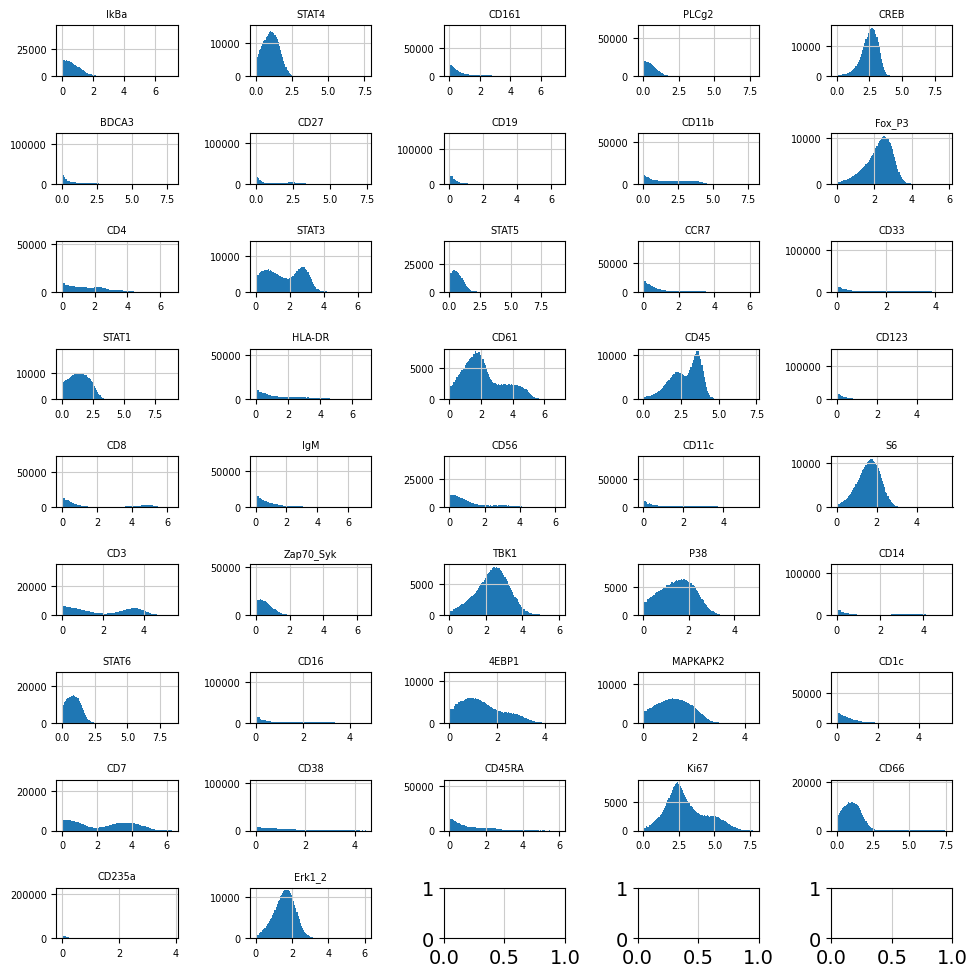

In [48]:
(fig,axes) = plt.subplots(9,5, figsize=(10,10), dpi=100)
for (i,g) in enumerate(outliers + list(set(adata.var.index)- set(outliers))):
    axes.ravel()[i].hist(adata.obs_vector(g), bins=100)
    axes.ravel()[i].set_title(g, fontsize=7)
    axes.ravel()[i].tick_params(labelsize=7)
plt.tight_layout()

In [49]:
for i in sumstats.index:
    colind = (adata.var.index==i)
    rowind = adata.obs_vector(i)>sumstats.at[i, '99.999th']
    adata.X[rowind, colind] = sumstats.at[i, '99.999th']

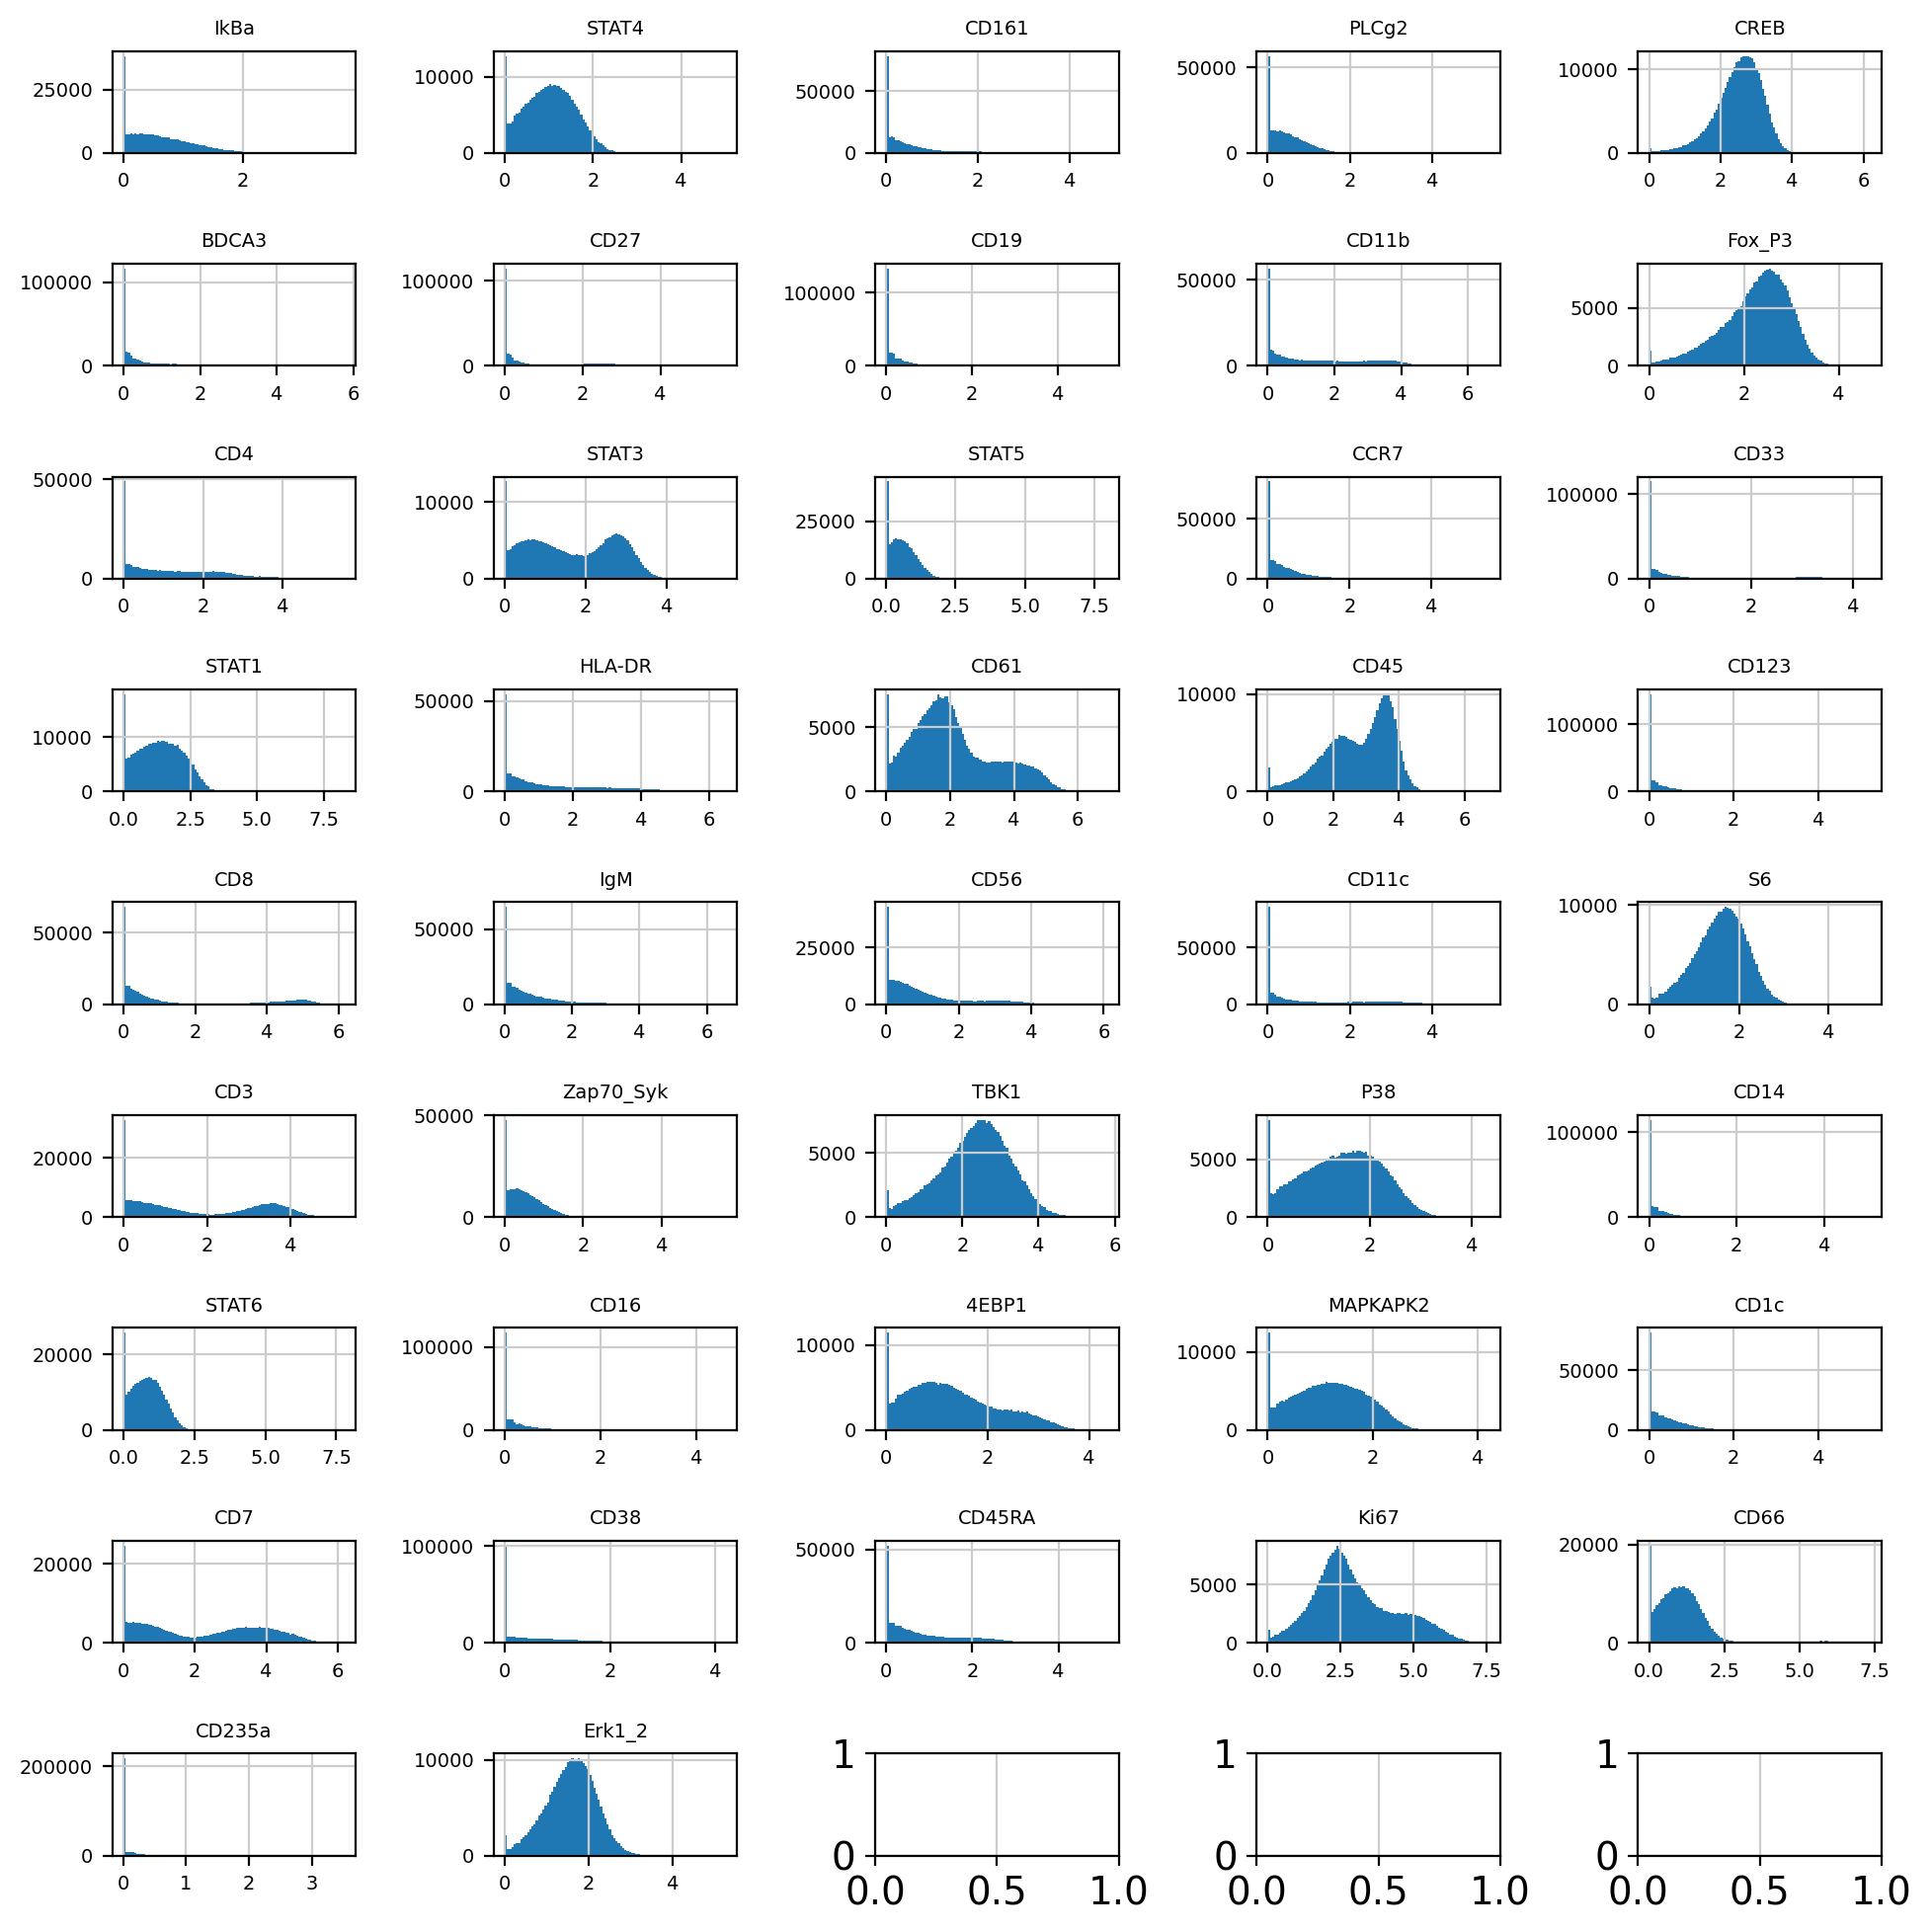

In [50]:
(fig,axes) = plt.subplots(9,5, figsize=(10,10), dpi=200)
for (i,g) in enumerate(outliers + list(set(adata.var.index)- set(outliers))):
    axes.ravel()[i].hist(adata.obs_vector(g), bins=100)
    axes.ravel()[i].set_title(g, fontsize=7)
    axes.ravel()[i].tick_params(labelsize=7)
plt.tight_layout()

In [51]:
sampled_transform_file = os.path.join(adir, project_name + '.transformed.h5ad')
print(sampled_transform_file)

../../../data/Emory/Emory_EVD_280K.transformed.h5ad


In [52]:
save_adata(adata, sampled_transform_file, ext='.h5ad', gcs=gcs)


In [53]:
adata = read_adata(sampled_transform_file, ext='.h5ad', gcs=gcs)


<a id="clustering1"></a>
## Initial clustering to remove doublets

In [51]:
pca_cytof(adata)

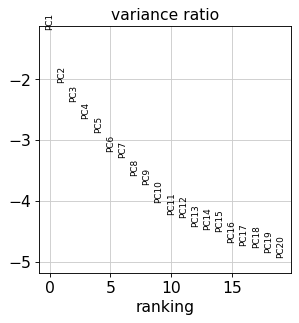

In [52]:
sc.pl.pca_variance_ratio(adata, log=True)

In [53]:
adata

AnnData object with n_obs × n_vars = 280000 × 42 
    obs: 'full_sample', 'sid', 'day', 'collectionday', 'eventNumber', 'Time', 'Event_length', 'BC1', 'Rh103Di', 'BC2', 'BC3', 'BC4', 'BC5', 'BC6', 'Sn120Di', 'I127Di', 'Xe131Di', 'Cs133Di', 'Ba138Di', 'DNA1', 'DNA2', 'Viability1', 'Viability2', 'Viability3', 'Viability4', 'Pb206Di', 'Pb208Di', 'day_fix'
    var: 'Channel', 'gene_symbol', 'Use'
    uns: 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

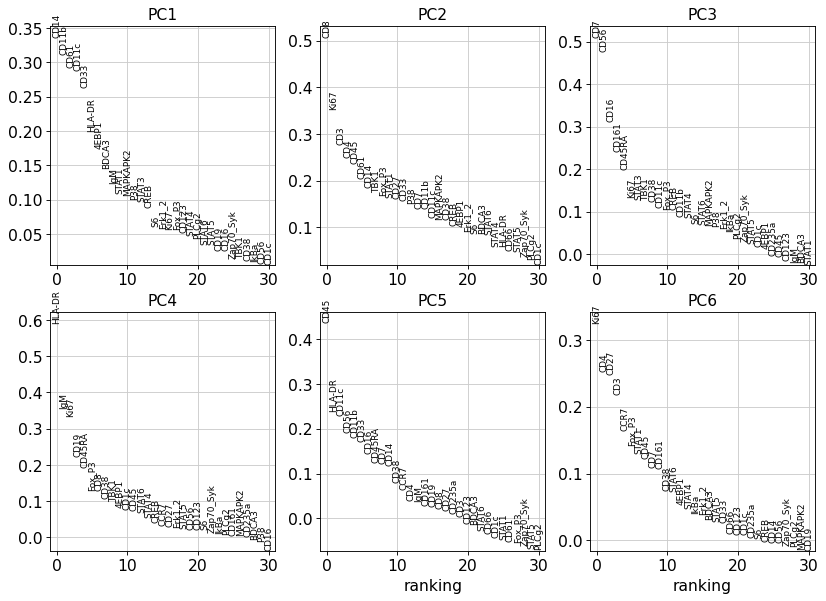

In [54]:
sc.pl.pca_loadings(adata, components=[1,2,3,4,5,6])

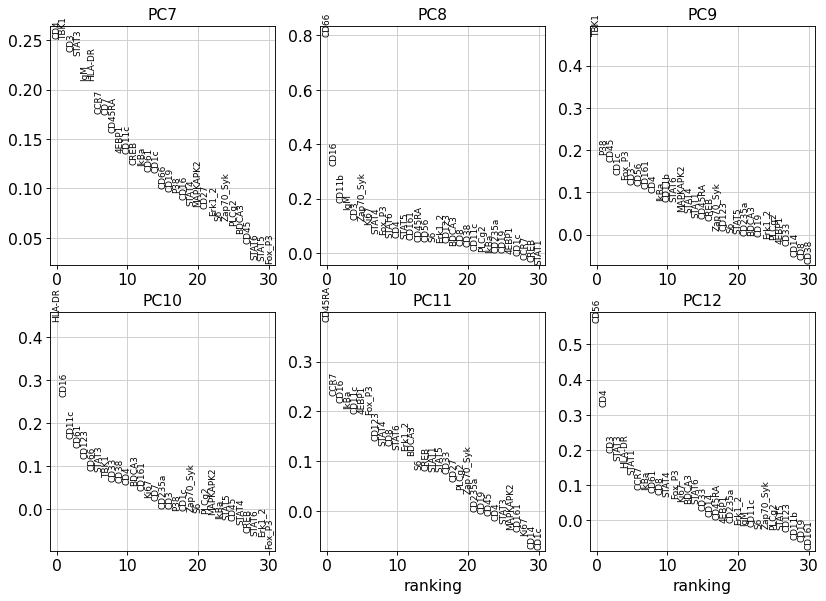

In [55]:
sc.pl.pca_loadings(adata, components=[7,8,9,10,11,12])

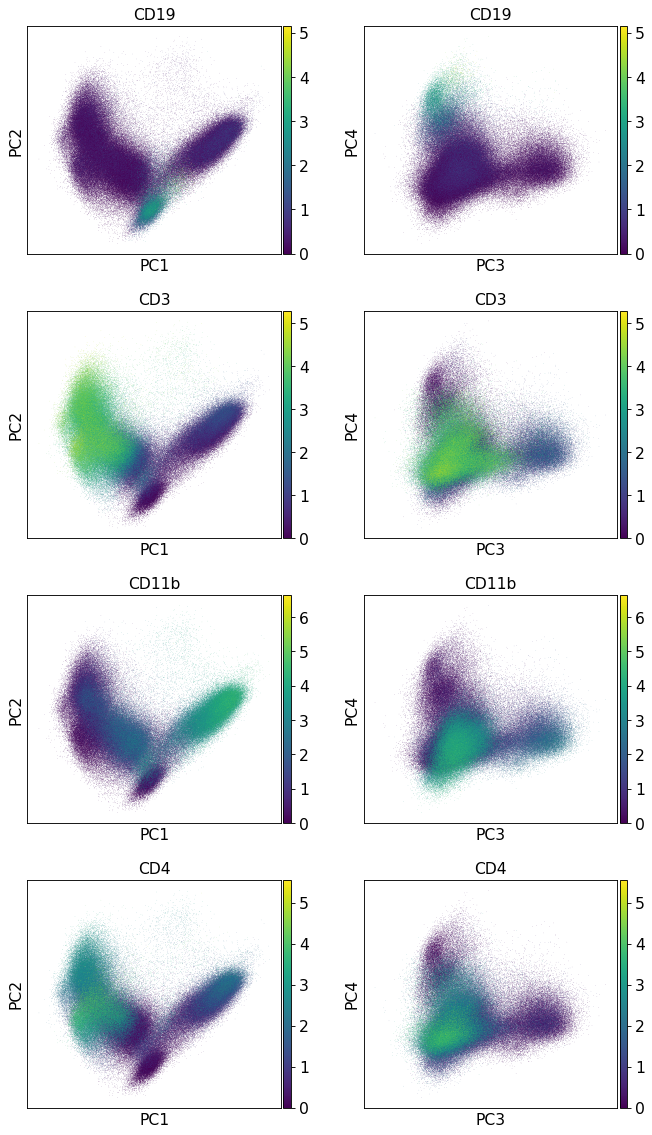

In [56]:
sc.pl.pca(adata, components=['1,2', '3,4'], color=['CD19', 'CD3',  'CD11b', 'CD4'],
          ncols=2)


In [57]:
adata

AnnData object with n_obs × n_vars = 280000 × 42 
    obs: 'full_sample', 'sid', 'day', 'collectionday', 'eventNumber', 'Time', 'Event_length', 'BC1', 'Rh103Di', 'BC2', 'BC3', 'BC4', 'BC5', 'BC6', 'Sn120Di', 'I127Di', 'Xe131Di', 'Cs133Di', 'Ba138Di', 'DNA1', 'DNA2', 'Viability1', 'Viability2', 'Viability3', 'Viability4', 'Pb206Di', 'Pb208Di', 'day_fix'
    var: 'Channel', 'gene_symbol', 'Use'
    uns: 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

In [103]:
Z = harmonize(adata.obsm['X_pca'], adata.obs, batch_key = 'collectionday', theta=.05, random_state=14)
adata.obsm['X_harmony'] = Z

	Initialization is completed.
	Completed 1 / 10 iteration(s).
	Completed 2 / 10 iteration(s).
	Completed 3 / 10 iteration(s).
	Completed 4 / 10 iteration(s).
	Completed 5 / 10 iteration(s).
	Completed 6 / 10 iteration(s).
Reach convergence after 6 iteration(s).


In [104]:
sc.pp.neighbors(adata, n_neighbors=int(adata.shape[0]*.001), n_pcs=16, random_state=14, use_rep='X_harmony')

/opt/miniconda3/envs/seqwell/lib/python3.7/site-packages/numba/typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../../../../../../opt/miniconda3/envs/seqwell/lib/python3.7/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  state.func_ir.loc))


In [105]:
sc.tl.umap(adata, min_dist=0.1, spread=2.0, random_state=14)

In [54]:
sample_file = os.path.join(adir, project_name + '.UMAP.h5ad')
sample_file

'../../../data/Emory/Emory_EVD_280K.UMAP.h5ad'

In [55]:
save_adata(adata, sample_file, ext='.h5ad', gcs=gcs)


In [56]:
adata = read_adata(sample_file, ext='.h5ad', gcs=gcs)


In [57]:
sc.pl.umap(adata, color='collectionday')

KeyError: 'X_umap'

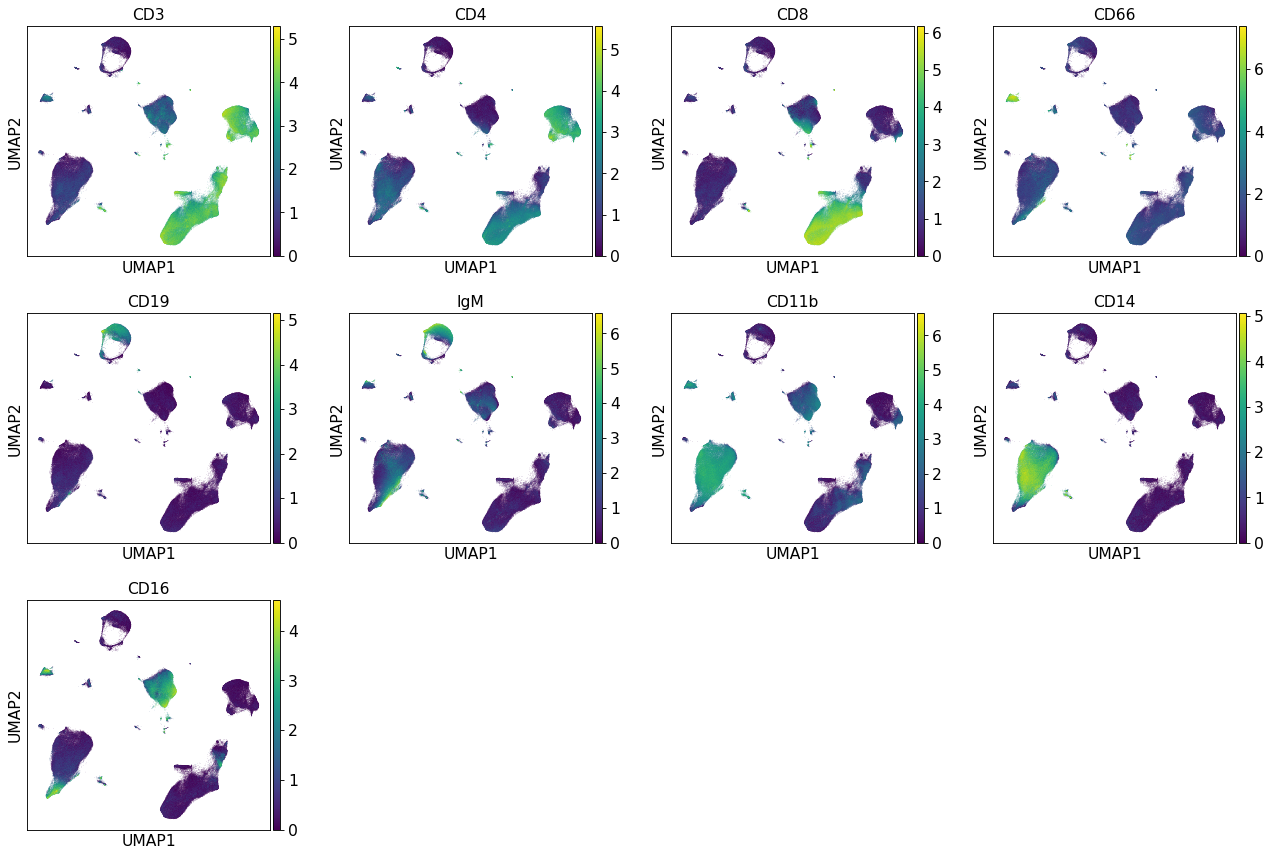

In [7]:
sc.pl.umap(adata, color=['CD3', 'CD4', 'CD8', 'CD66','CD19', 'IgM', 'CD11b', 'CD14', 'CD16'])


In [8]:
sc.tl.leiden(adata, resolution=1.0, random_state=14)

In [9]:
adata.obs['leiden'].value_counts()

0     44742
1     34388
2     34346
3     30209
4     25949
5     20675
6     18618
7     16729
8     14349
9      8964
10     6930
11     6074
12     4889
13     4413
14     2925
15     2924
16     1515
17      957
18      404
Name: leiden, dtype: int64

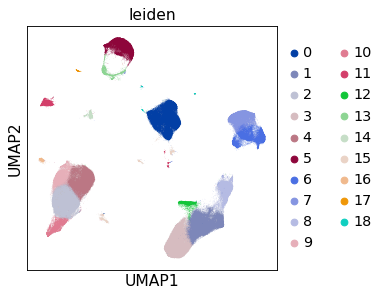

In [10]:
sc.pl.umap(adata, color='leiden')

In [14]:
sc.tl.rank_genes_groups(adata, 'leiden', method='wilcoxon')

In [15]:
sample_file2 = os.path.join(adir, project_name + '.UMAP.Leiden.h5ad')

In [16]:
save_adata(adata, sample_file2, ext='.h5ad', gcs=gcs)

Only considering the two last: ['.Leiden', '.h5ad'].
Only considering the two last: ['.Leiden', '.h5ad'].


In [17]:
pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(8)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,CD56,CD8,CD14,CD8,CD11b,CD19,CD4,CD4,CD3,CD14,CD11c,CD66,CCR7,Ki67,CD123,S6,HLA-DR,CD123,IgM
1,CD7,CD3,CD33,Ki67,Ki67,IgM,CD3,CD27,CD7,CD11b,CD16,CD16,CD27,CD38,CD38,CD61,CD11c,HLA-DR,CD19
2,CD16,CD4,CD61,CD27,BDCA3,HLA-DR,TBK1,CCR7,CD161,CD33,BDCA3,Zap70_Syk,CD8,CD19,CD66,Fox_P3,IkBa,BDCA3,CD45RA
3,CD161,CD7,CD11c,CD3,CD14,CD45RA,CD1c,CD3,TBK1,CD61,CD123,CD11b,CD3,IgM,CD11b,Erk1_2,4EBP1,CREB,HLA-DR
4,CD45RA,TBK1,CD11b,CD45,STAT1,CCR7,CD66,CD7,CD66,CD11c,HLA-DR,IgM,CD7,CD27,STAT5,STAT6,CD33,CCR7,CCR7
5,CD38,CD27,4EBP1,CD4,CD61,CD1c,IkBa,CD66,CD45RA,MAPKAPK2,4EBP1,CD11c,CD45RA,CD45RA,P38,CREB,CD1c,CD4,CREB
6,CD11c,CD45,BDCA3,CD38,4EBP1,4EBP1,CD27,IkBa,CD1c,BDCA3,CD61,STAT5,CD4,STAT5,CD33,STAT4,BDCA3,4EBP1,Fox_P3
7,IkBa,CD66,MAPKAPK2,CD7,CD33,IkBa,CD161,CD235a,STAT3,STAT1,CD33,CD235a,CD66,HLA-DR,CD61,BDCA3,CREB,PLCg2,CD1c


In [18]:
pd.DataFrame(adata.uns['rank_genes_groups']['scores']).head(8)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,285.585541,252.581284,277.824585,246.230484,182.878906,220.354950,199.717850,165.965485,125.471352,129.153305,135.791336,133.400146,108.784355,74.006821,88.063637,62.079773,58.647263,53.158577,31.776705
1,276.953308,171.560181,266.604279,224.531113,182.301895,213.997437,131.033783,161.672333,72.976974,125.812813,121.890602,93.423500,93.790016,48.235165,44.299870,61.737919,55.192223,44.209091,31.644585
2,262.704407,137.900345,265.185913,198.883255,177.825348,196.039459,71.991013,161.234665,63.869820,112.223724,121.081497,80.974625,73.238503,38.584957,33.806248,59.961002,52.526695,38.486237,28.899200
3,217.137558,84.447845,261.798676,187.547348,177.130600,159.781403,49.845768,146.009811,48.111809,109.930344,114.358376,68.083755,72.347130,28.977488,32.882187,58.187393,50.205269,31.659672,27.757605
4,198.735855,83.760185,259.725220,154.781036,157.633179,104.851212,40.945637,79.635628,29.230494,109.920624,111.633644,40.054062,53.305050,28.148928,26.505987,55.037266,48.506927,28.902302,21.945316
5,150.505997,67.502808,248.598648,153.116547,154.462387,34.081158,40.879513,37.955318,23.355389,47.819313,96.988304,12.021111,53.279701,27.687275,24.837383,53.665382,46.831387,26.058975,20.197634
6,68.524963,64.662064,234.304901,150.309311,154.233002,18.677555,36.984608,-4.166975,23.134125,41.559605,93.175682,5.241618,18.992767,27.273424,22.833273,53.267212,45.422089,25.985064,19.142120
7,36.876217,34.144272,209.280411,106.568047,153.416016,-13.202834,22.491804,-8.639819,17.094194,41.418468,86.347618,0.867782,10.379684,24.147268,21.003860,51.439468,38.129906,25.066912,18.607910


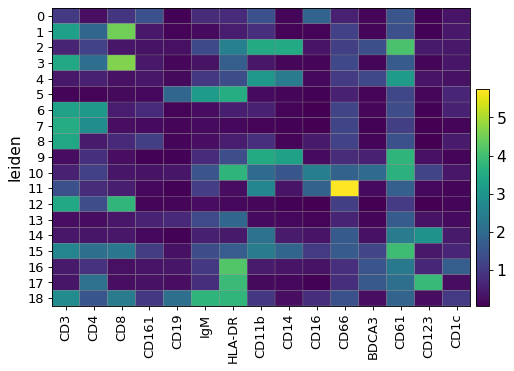

In [21]:
marker_genes = ['CD3', 'CD4', 'CD8', 'CD161', 'CD19', 'IgM', 'HLA-DR', 'CD11b', 'CD14', 'CD16', 'CD66', 'BDCA3', 'CD61', 'CD123', 'CD1c']
#gs = sc.pl.matrixplot(adata,marker_genes, groupby='leiden', figsize=(7,5),standard_scale='var')
gs = sc.pl.matrixplot(adata,marker_genes, groupby='leiden', figsize=(7,5))

In [22]:
labmap = {'0':'NK 1', '1':'Tc 1', '2':'Mono 1', '3':'Tc 2',
          '4':'Mono 2', '5':'B 1', '6':'Th 1', '7':'Th 2', 
          '8':'NK/T 1', '9':'Mono 3', '10':'Mono 4', '11':'Neut 1',
          '12':'Tc 3', '13':'B 2', '14':'Basophil 1',
          '15':'Doublet 1', '16':'DC 1', '17':'DC 2',
          '18':'Doublet 2'}



In [23]:
adata.obs['leiden_lab'] = adata.obs['leiden'].replace(labmap)

In [24]:
adata.obs['leiden_lab_group'] = adata.obs['leiden_lab'].apply(lambda x: x.split(' ')[0])

... storing 'leiden_lab' as categorical
... storing 'leiden_lab_group' as categorical


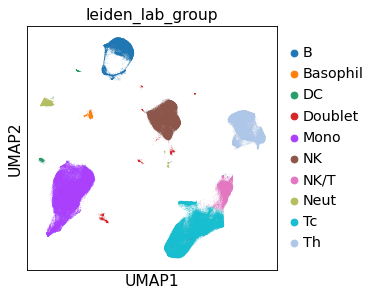

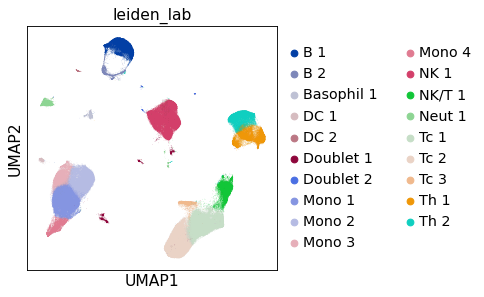

In [25]:
sc.pl.umap(adata, color=['leiden_lab_group'])
sc.pl.umap(adata, color=['leiden_lab'])


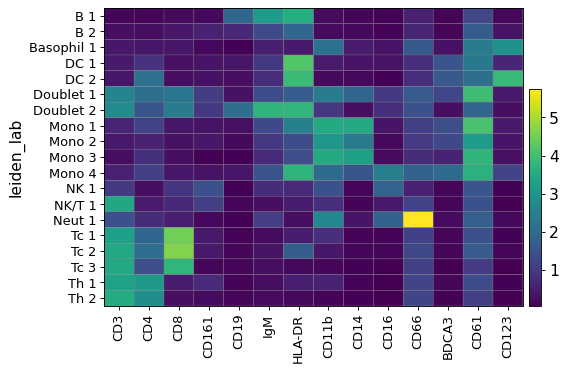

In [26]:
marker_genes = ['CD3', 'CD4', 'CD8', 'CD161', 'CD19', 'IgM', 'HLA-DR', 'CD11b', 'CD14', 'CD16', 'CD66', 'BDCA3', 'CD61', 'CD123']
gs = sc.pl.matrixplot(adata,marker_genes, groupby='leiden_lab', figsize=(7,5))

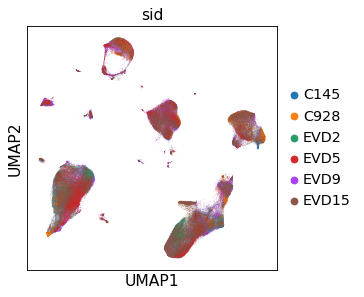

In [27]:
sc.pl.umap(adata, color='sid')

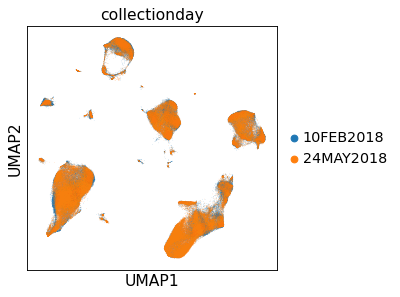

In [28]:
sc.pl.umap(adata, color='collectionday')

In [29]:
adata.obs['day'].value_counts()

May    40000
Feb    40000
D28    20000
D25    20000
D20    20000
D19    20000
D17    20000
D14    20000
D12    20000
D7     20000
D6     20000
D2     20000
Name: day, dtype: int64

In [30]:
adata.obs['day_fix'] = adata.obs['day'].astype(str)
ind = adata.obs['day'].isin(['March6', 'April9', 'April3', 'May', 'Feb'])
adata.obs.loc[ind, 'day_fix'] = 'Control'
pd.crosstab(adata.obs['sid'], adata.obs['day_fix'])

day_fix,Control,D12,D14,D17,D19,D2,D20,D25,D28,D6,D7
sid,,,,,,,,,,,
C145,40000,0,0,0,0,0,0,0,0,0,0
C928,40000,0,0,0,0,0,0,0,0,0,0
EVD2,0,20000,0,0,20000,0,0,0,0,0,0
EVD5,0,0,0,20000,0,0,0,20000,0,0,0
EVD9,0,0,20000,0,0,0,20000,0,20000,20000,0
EVD15,0,0,0,0,0,20000,0,0,0,0,20000


In [31]:
pd.crosstab([adata.obs['sid'], adata.obs['day_fix']], adata.obs['collectionday'])

collectionday  10FEB2018  24MAY2018
sid   day_fix                      
C145  Control      20000      20000
C928  Control      20000      20000
EVD2  D12              0      20000
      D19              0      20000
EVD5  D17              0      20000
      D25              0      20000
EVD9  D14          20000          0
      D20          20000          0
      D28          20000          0
      D6           20000          0
EVD15 D2               0      20000
      D7               0      20000

In [32]:
adata.obs['is_control'] = (adata.obs['day_fix']=='Control').astype(str)

... storing 'day_fix' as categorical
... storing 'is_control' as categorical


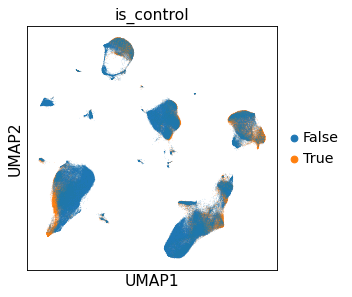

In [33]:
sc.pl.umap(adata, color='is_control')

In [34]:
sc.tl.rank_genes_groups(adata, 'leiden_lab', method='wilcoxon')

In [35]:
pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(8).T

,0,1,2,3,4,5,6,7
B 1,CD19,IgM,HLA-DR,CD45RA,CCR7,CD1c,4EBP1,IkBa
B 2,Ki67,CD38,CD19,IgM,CD27,CD45RA,STAT5,HLA-DR
Basophil 1,CD123,CD38,CD66,CD11b,STAT5,P38,CD33,CD61
DC 1,HLA-DR,CD11c,IkBa,4EBP1,CD33,CD1c,BDCA3,CREB
DC 2,CD123,HLA-DR,BDCA3,CREB,CCR7,CD4,4EBP1,PLCg2
Doublet 1,S6,CD61,Fox_P3,Erk1_2,STAT6,CREB,STAT4,BDCA3
Doublet 2,IgM,CD19,CD45RA,HLA-DR,CCR7,CREB,Fox_P3,CD1c
Mono 1,CD14,CD33,CD61,CD11c,CD11b,4EBP1,BDCA3,MAPKAPK2
Mono 2,CD11b,Ki67,BDCA3,CD14,STAT1,CD61,4EBP1,CD33
Mono 3,CD14,CD11b,CD33,CD61,CD11c,MAPKAPK2,BDCA3,STAT1


In [36]:
adata

AnnData object with n_obs × n_vars = 280000 × 42 
    obs: 'full_sample', 'sid', 'day', 'collectionday', 'eventNumber', 'Time', 'Event_length', 'BC1', 'Rh103Di', 'BC2', 'BC3', 'BC4', 'BC5', 'BC6', 'Sn120Di', 'I127Di', 'Xe131Di', 'Cs133Di', 'Ba138Di', 'DNA1', 'DNA2', 'Viability1', 'Viability2', 'Viability3', 'Viability4', 'Pb206Di', 'Pb208Di', 'day_fix', 'leiden', 'leiden_lab', 'leiden_lab_group', 'is_control'
    var: 'Channel', 'gene_symbol', 'Use'
    uns: 'collectionday_colors', 'leiden', 'leiden_colors', 'leiden_lab_colors', 'leiden_lab_group_colors', 'neighbors', 'pca', 'rank_genes_groups', 'sid_colors', 'is_control_colors'
    obsm: 'X_harmony', 'X_pca', 'X_umap'
    varm: 'PCs'

In [3]:
sample_file2 = os.path.join(adir, project_name + '.UMAP.Leiden.h5ad')

In [38]:
save_adata(adata, sample_file2, ext='.h5ad', gcs=gcs)

Only considering the two last: ['.Leiden', '.h5ad'].
Only considering the two last: ['.Leiden', '.h5ad'].


In [4]:
adata = read_adata(sample_file2, ext='.h5ad', gcs=gcs)

Only considering the two last: ['.Leiden', '.h5ad'].
Only considering the two last: ['.Leiden', '.h5ad'].


In [5]:
obs = adata.obs[['sid', 'day_fix', 'leiden_lab_group', 'collectionday']].copy()
for c in ['CD14', 'CD16', 'HLA-DR', 'Ki67', 'CD38']:
    obs[c] = adata.obs_vector(c)

In [6]:
obs_B = obs.loc[obs['leiden_lab_group']=='B',:]
obs_B.head()

,sid,day_fix,leiden_lab_group,collectionday,CD14,CD16,HLA-DR,Ki67,CD38
10FEB2018_C145_Feb_54064,C145,Control,B,10FEB2018,0.000000,0.381563,3.269798,2.306884,0.560302
10FEB2018_C145_Feb_37059,C145,Control,B,10FEB2018,0.313745,0.231747,2.909095,3.032282,0.000000
10FEB2018_C145_Feb_55026,C145,Control,B,10FEB2018,0.000000,0.000000,4.210081,1.677562,0.000000
10FEB2018_C145_Feb_44585,C145,Control,B,10FEB2018,0.033270,0.000000,3.017532,3.081177,0.000000
10FEB2018_C145_Feb_13164,C145,Control,B,10FEB2018,0.049715,0.072238,2.745887,1.681811,0.000000


In [7]:
obs_B['sample_merge'] = obs_B['sid'].copy().astype(str)
ind = (obs_B['day_fix']=='Control')
obs_B.loc[ind, 'sample_merge'] = 'Control'
obs_B['sample_merge'].unique()

/opt/miniconda3/envs/seqwell/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/opt/miniconda3/envs/seqwell/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


array(['Control', 'EVD9', 'EVD2', 'EVD5', 'EVD15'], dtype=object)

In [8]:
obs_B['day_fix_int'] = obs_B['day_fix'].replace({'Control':'D0'}).apply(lambda x: x[1:]).astype(int)

/opt/miniconda3/envs/seqwell/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [9]:
pd.crosstab([obs_B['sid'], obs_B['day_fix']], obs_B['collectionday'])

collectionday  10FEB2018  24MAY2018
sid   day_fix                      
C145  Control       1009       1156
C928  Control       4141       4036
EVD2  D12              0        475
      D19              0       1109
EVD5  D17              0       2142
      D25              0       1057
EVD9  D6            3244          0
      D14           2948          0
      D20           1428          0
      D28            789          0
EVD15 D2               0        852
      D7               0        702

/opt/miniconda3/envs/seqwell/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/opt/miniconda3/envs/seqwell/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/opt/miniconda3/envs/seqwell/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats i

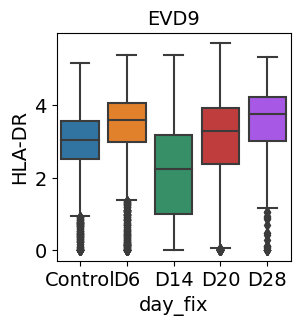

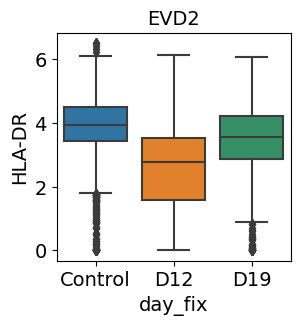

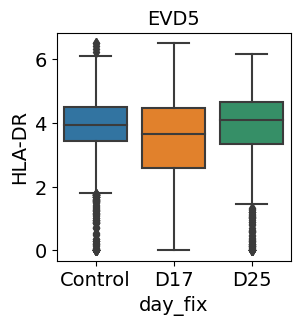

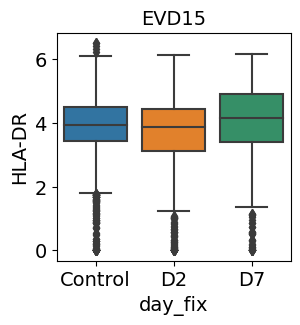

In [10]:
for sid in ['EVD9', 'EVD2', 'EVD5', 'EVD15']:
    cday = obs_B.loc[obs_B['sid']==sid, 'collectionday'].unique()[0]
    ind = obs_B['sample_merge'].isin([sid, 'Control']) & (obs_B['collectionday']==cday)
    subdat = obs_B.loc[ind,:]
    subdat['day_fix'] = subdat['day_fix'].astype(str)
    (fig,ax) = plt.subplots(1,1, figsize=(3,3), dpi=100)
    sns.boxplot(x='day_fix', y='HLA-DR', data=subdat, ax=ax)
    ax.set_title(sid)
    ax.grid(False)

## Scratch

In [ ]:
sc.pl.umap(adata, color=['Multiplex_Group'])

In [ ]:
res = {}
for (k,g) in adata.obs.groupby('sample'):
    vc = g['leiden_lab_group'].value_counts()
    vc = vc.loc[['Tc', 'Th', 'T_low']]
    res[k] = vc.div(vc.sum())
    
    
res = pd.DataFrame.from_dict(res).T

dpic = np.array([int(x.split('.')[1][1:]) for x in res.index])
dpic[dpic<0]=0
dpi_color = [dpimap[str(x)] for x in dpic]
X = adata.obs[['sample', 'Multiplex_Group']].drop_duplicates()
samp2group = dict(zip(X['sample'], X['Multiplex_Group'].apply(lambda x: x.split(' ')[-1])))
multiplex_color = [palettable.tableau.Tableau_10.hex_colors[int(samp2group[x])-1] for x in res.index]
sns.clustermap(res.astype(float), row_colors=[dpi_color,multiplex_color])

### Suggests that the T low cluster is an artifact and is enriched for a specific  multiplex group

In [ ]:
sc.pl.violin(adata, keys=['intensity_sum'], groupby='leiden_lab_group', rotation=90, jitter=False)

In [ ]:
list(adata.obs['leiden_lab_group'].unique())

In [ ]:
adata.obs['is_doublet'] = adata.obs['leiden_lab_group'].apply(lambda x: ('doublet' in x) or ('multiplet' in x))
pd.crosstab(adata.obs['leiden_lab_group'], adata.obs['is_doublet'])

In [ ]:
sc.pl.umap(adata, color=['is_doublet', 'leiden_lab'])

In [ ]:
sample_file2 = os.path.join(adir, project_name + '.UMAP.Leiden.h5ad')

In [ ]:
save_adata(adata, sample_file2, ext='.h5ad', gcs=gcs)

In [ ]:
adata = read_adata(sample_file2, ext='.h5ad', gcs=gcs)

<a id="filter_doublets_RBC_Tlow"></a>
## Filter doublets, RBC, and Tlow cluster

In [ ]:
adata

In [ ]:
adata.obs['leiden_lab_group'].value_counts()

In [ ]:
tofilter = adata.obs['leiden_lab_group'].isin(['T_low', 'RBC']) | (adata.obs['is_doublet']=='True')

In [ ]:
pd.crosstab(tofilter, adata.obs['leiden_lab_group'])

In [ ]:
adata = adata[~tofilter, :]

In [ ]:
adata.obs['leiden_lab_group'].value_counts()

In [ ]:
sc.pl.umap(adata, color=['leiden_lab_group'])


<a id="batch_per_celltype"></a>
## COMBAT batch correction per cell-type

In [ ]:
adata_corrected = []
for c in list(adata.obs['leiden_lab_group'].unique()):
    ind = adata.obs.index[adata.obs['leiden_lab_group']==c]
    Z = adata[ind,:]
    sc.pp.combat(Z, key='Multiplex_Group', inplace=True)
    adata_corrected.append(Z.copy())

In [ ]:
adata_corrected = adata_corrected[0].concatenate(adata_corrected[1:])

In [ ]:
sample_file3 = os.path.join(adir, project_name + '.DoubletFilt.COMBAT.h5ad')

In [ ]:
adata_corrected

In [ ]:
save_adata(adata_corrected, sample_file3, ext='.h5ad', gcs=gcs)

In [ ]:
adata

<a id="clustering2"></a>
## Can optionally repeat clustering after COMBAT before cNMF

<a id="cNMF"></a>
## Run cNMF and regress out platelet / fixation artifact

In [ ]:
adata_noneg = adata.copy()
adata_noneg.X[adata_noneg.X<0]=0

In [ ]:
cnmfdir = os.path.join(adir, 'cNMF')
if not os.path.exists(cnmfdir):
    os.mkdir(cnmfdir)

In [ ]:
hvgfn = os.path.join(cnmfdir, 'hvgs.txt')
with open(hvgfn, 'w') as F:
    F.write('\n'.join(adata_noneg.var.index))

In [ ]:
adata_noneg_fn = os.path.join(adir, project_name + '.DoubletFilt.COMBAT.NoNegative.h5ad')
adata_noneg_fn_npz = os.path.join(adir, project_name + '.DoubletFilt.COMBAT.NoNegative.npz')


In [ ]:
adata_noneg.uns = {}
adata_noneg.obsm = None
adata_noneg.varm = None

In [ ]:
sc.write(adata_noneg_fn, adata_noneg)

In [ ]:
adata_noneg

In [ ]:
X = pd.DataFrame(adata_noneg.X, index=adata_noneg.obs.index, columns=adata_noneg.var.index)
save_df_to_npz(X, adata_noneg_fn_npz)
del(X)

In [ ]:
## This needs to be run from the cnmf_env environment in the command line
NAME = project_name + '.DoubletFilt.COMBAT.NoNegative'
OUTDIR = cnmfdir
COUNT = adata_noneg_fn
HVG = hvgfn
SEED = 14
NITER = 20
Ks = ' '.join([str(x) for x in range(6,16)])
NUMWORKERS = 100

if not os.path.exists(OUTDIR):
    os.mkdir(OUTDIR)

cmd = 'python ../../../Code/cNMF/cnmf_nonorm.py prepare --name {NAME} --output-dir {OUTDIR} \
-c {COUNT} -k {Ks} -n {NITER} --seed {SEED} --genes-file {HVG} --total-workers {NUMWORKERS} --beta-loss frobenius --tpm {COUNT}'.format(NAME=NAME, OUTDIR=OUTDIR, COUNT=adata_noneg_fn_npz, Ks=Ks, NITER=NITER, SEED=SEED, HVG=HVG, NUMWORKERS=NUMWORKERS)
print(cmd)
#!{cmd}

In [ ]:
NAME = project_name + '.DoubletFilt.COMBAT.NoNegative'
OUTDIR = cnmfdir

cmd = 'python ../../../Code/cNMF/cnmf_nonorm.py combine --name {NAME} --output-dir {OUTDIR}'.format(NAME=NAME, OUTDIR=OUTDIR)
print(cmd)
!{cmd}

In [ ]:
cmd = 'python ../../../Code/cNMF/cnmf_nonorm.py k_selection_plot --name {NAME} --output-dir {OUTDIR}'.format(NAME=NAME, OUTDIR=OUTDIR)
print(cmd)
!{cmd}

In [ ]:
from IPython.display import Image
image_fn = os.path.join(OUTDIR, NAME, NAME+".k_selection.png")
Image(filename = image_fn,
      width=1000, height=1000)

In [ ]:
selected_K = 7
density_threshold = 2.00
density_threshold_str = ('%.2f' % density_threshold).replace('.', '_')


In [ ]:
cmd = 'python ../../../Code/cNMF/cnmf_nonorm.py consensus -k %d --name %s --output-dir %s --local-density-threshold %.2f --show-clustering' % (selected_K, NAME, OUTDIR, density_threshold)
print(cmd)
!{cmd}

In [ ]:
consensus_plot_fn = os.path.join(OUTDIR, NAME, NAME+".clustering.k_%d.dt_%s.png" % (selected_K, density_threshold_str))
Image(filename = consensus_plot_fn,
      width=1000, height=1000)

In [ ]:
component_fn = os.path.join(OUTDIR, NAME, NAME+".gene_spectra_score.k_%d.dt_%s.txt" % (selected_K, density_threshold_str))
components = pd.read_csv(component_fn,
                     sep='\t', index_col=0).T

topgenes = []
topscores = []
for c in components.columns:
    topgenes.append(components.sort_values(by=c, ascending=False).index[:20])
    topscores.append(components[c].sort_values(ascending=False).values[:20])
topgenes = pd.DataFrame(topgenes).T
topscores = pd.DataFrame(topscores).T
topgenes.columns = components.columns
topscores.columns = topscores.columns

topgenes.head(10)

In [ ]:
usage_fn = os.path.join(OUTDIR, NAME, NAME+".usages.k_%d.dt_%s.consensus.txt" % (selected_K, density_threshold_str))

usage = pd.read_csv(usage_fn, sep='\t', index_col=0)
usage.columns = ['Usage_%s' % i for i in usage.columns]
usage_norm = usage.div(usage.sum(axis=1), axis=0)
usage_norm.head()

In [ ]:
overlap = list(set(usage_norm.columns).intersection(set(adata.obs.columns)))
adata.obs.drop(overlap, axis=1, inplace=True)

In [ ]:
adata.obs = pd.merge(left=adata.obs, right=usage_norm, how='left', left_index=True, right_index=True)

In [ ]:
sc.pl.umap(adata, color=usage_norm.columns, ncols=3, vmin=0, vmax=.5)

In [ ]:
adata_noneg = read_adata(adata_noneg_fn, gcs=gcs)

In [ ]:
spec_fn = os.path.join(OUTDIR, NAME, NAME+".spectra.k_%d.dt_%s.consensus.txt" % (selected_K, density_threshold_str))

spec = pd.read_csv(spec_fn, sep='\t', index_col=0)
spec.head()

In [ ]:
usage = pd.read_csv(usage_fn, sep='\t', index_col=0)
usage.columns = np.arange(1,selected_K+1)
usage.head()


In [ ]:
geps_to_regress = [3,5]

In [ ]:
adata_noneg.X = adata_noneg.X - usage.loc[:, geps_to_regress].dot(spec.loc[geps_to_regress, :]).values

In [ ]:
order = sorted(adata.obs['leiden_lab'].unique())

In [ ]:
(fig,ax) = plt.subplots(1,1, figsize=(8,2))
sns.violinplot(x='leiden_lab', y='Usage_3', data=adata.obs, ax=ax, order=order)
ax.set_xticklabels(order, rotation=90)

In [ ]:
(fig,ax) = plt.subplots(1,1, figsize=(8,2))
sns.violinplot(x='leiden_lab', y='Usage_5', data=adata.obs, ax=ax, order=order)
ax.set_xticklabels(order, rotation=90)

In [ ]:
ind = (adata_noneg.obs['leiden_lab_group'] !='Platelet')
adata_noneg = adata_noneg[ind,:]

In [ ]:
sample_file = os.path.join(adir, project_name + '.DoubletFilt.COMBAT.SubtractCNMF.h5ad')
sample_file

In [ ]:
save_adata(adata_noneg, sample_file, ext='.h5ad', gcs=gcs)

<a id="clustering3"></a>
## Run next iteration of clustering on the COMBAT / cNMF corrected data

In [ ]:
adata = adata_noneg

In [ ]:
pca_cytof(adata)

In [ ]:
sc.pl.pca_variance_ratio(adata, log=True)

In [ ]:
adata

In [ ]:
sc.pl.pca_loadings(adata, components=[1,2,3,4,5,6])

In [ ]:
sc.pl.pca_loadings(adata, components=[7,8,9,10,11,12])

In [ ]:
adata

In [ ]:
from joblib import parallel_backend
with parallel_backend('threading', n_jobs=15):
    sc.pp.neighbors(adata, n_neighbors=int(adata.shape[0]*.0001), n_pcs=16, random_state=14)

In [ ]:
with parallel_backend('threading', n_jobs=15):
    sc.tl.umap(adata, min_dist=0.1, spread=2.0)

In [ ]:
sample_file = os.path.join(adir, project_name + '.DoubletFilt.COMBAT.SubtractCNMF.UMAP.h5ad')


In [ ]:
save_adata(adata, sample_file, ext='.h5ad', gcs=gcs)


In [ ]:
adata = read_adata(sample_file, ext='.h5ad', gcs=gcs)


In [ ]:
adata.obs.columns

In [ ]:
sc.pl.umap(adata, color=['leiden_lab_group'])
sc.pl.umap(adata, color=['leiden_lab'])


In [ ]:

sc.pl.umap(adata, color=['CD61'])
sc.pl.umap(adata, color=['STAT4'], vmax=2)
sc.pl.umap(adata, color=['DPIc'],sort_order=False, alpha=.7,
           palette=[dpimap[str(i)] for i in range(9)], legend_fontsize=8)

In [ ]:
np.random.seed(14)
with parallel_backend('threading', n_jobs=15):
    sc.tl.leiden(adata, resolution=1.0, random_state=14)

In [ ]:
adata.obs['leiden'].value_counts()

In [ ]:
sample_file = os.path.join(adir, project_name + '.DoubletFilt.COMBAT.SubtractCNMF.UMAP.Leiden.h5ad')


In [ ]:
save_adata(adata, sample_file, ext='.h5ad', gcs=gcs)


In [ ]:
adata = read_adata(sample_file, ext='.h5ad', gcs=gcs)


In [ ]:
sc.pl.umap(adata, color=['leiden'])

In [ ]:
sc.tl.rank_genes_groups(adata, 'leiden', method='wilcoxon')

In [ ]:
pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(8)

In [ ]:
adata.obs['leiden14'] = (adata.obs['leiden']=='14').astype(str)
adata.obs['leiden13'] = (adata.obs['leiden']=='13').astype(str)
sc.pl.umap(adata, color=['leiden13', 'leiden14'])

In [ ]:
labmap = {'0':'Th 1', '1':'Neut 1', '2':'B 1', '3':'Tc 1', '4':'Mono/DC 1', '5':'Tc 2', '6':'NK 1', '7':'Neut 2', 
          '8':'HLA-DR_high 1', '9':'Th 2', '10':'Th 3', '11':'Mono/DC 2', '12':'RBC', '13':'NK 2', '14':'Plasmablast'}

In [ ]:
adata.obs['leiden_lab'] = adata.obs['leiden'].replace(labmap)
adata.obs['leiden_lab_group'] = adata.obs['leiden_lab'].apply(lambda x: x.split(' ')[0])

In [ ]:
adata.obs['leiden_lab_group'].value_counts()

In [ ]:
sc.pl.umap(adata, color=['leiden_lab_group'])
sc.pl.umap(adata, color=['leiden_lab'])

In [ ]:
marker_genes = ['CD3', 'CD4', 'CD8', 'CD161', 'CD19', 'IgM', 'HLA-DR', 'CD11b', 'CD14', 'CD16', 'CD66', 'BDCA3', 'CD61', 'CD235a']
gs = sc.pl.matrixplot(adata,marker_genes, groupby='leiden_lab', figsize=(7,5))

In [ ]:
#### These will be filled in in the upcoming subclustering steps
adata.obs['Subclustering'] = np.nan
adata.obs['SubclusteringGroup'] = np.nan
adata.obs['Doublet'] = False

In [ ]:
sample_file = os.path.join(adir, project_name + '.DoubletFilt.COMBAT.SubtractCNMF.UMAP.Leiden.h5ad')

In [ ]:
save_adata(adata, sample_file, ext='.h5ad', gcs=gcs)


In [ ]:
adata = read_adata(sample_file, ext='.h5ad', gcs=gcs)


<a id="Subclustering"></a>
## Run subclustering on B-cells, myeloid cells, and T/NK cells

In [ ]:
base_nbcommand = '''jupyter nbconvert --ExecutePreprocessor.allow_errors=True --ExecutePreprocessor.timeout=-1 --ExecutePreprocessor.timeout=-1 \
--FilesWriter.build_directory=../../../../results --execute %s'''


In [ ]:
! {base_nbcommand % 'Subclustering/Subcluster.Cytof.B.ipynb'}
! {base_nbcommand % 'Subclustering/Subcluster.Cytof.Myeloid.ipynb'}
! {base_nbcommand % 'Subclustering/Subcluster.Cytof.TNK.ipynb'}

<a id="clustering4"></a>
## Final sub-clustering after filtering doublets found during subclustering

In [ ]:
subcluster_out_fn = os.path.join(adir, project_name + '.DoubletFilt.COMBAT.SubtractCNMF.UMAP.Leiden.SubclusterBMyeloidTNK.h5ad')



In [ ]:
adata = read_adata(subcluster_out_fn, ext='.h5ad', gcs=gcs)


In [ ]:
pd.crosstab(adata.obs['leiden_lab_group'], adata.obs['Subclustering']).T

In [ ]:
adata.obs['SubclusteringGroup'].value_counts()

In [ ]:
adata.obs.loc[adata.obs['SubclusteringGroup'].isin(['nan', 'Doublet']), 'Subclustering'].value_counts()

In [ ]:
adata = adata[~adata.obs['SubclusteringGroup'].isin(['nan', 'Doublet']), :]

In [ ]:
adata.obs['SubclusteringGroup'].value_counts()

In [ ]:
adata.obs['Subclustering_reduced'] = adata.obs['SubclusteringGroup'].apply(lambda x: x.split('_')[0]).replace({'Unassigned':'Unassigned_APC'})

In [ ]:
adata.obs['Subclustering_reduced'].value_counts()

In [ ]:
pca_cytof(adata)

In [ ]:
sc.pl.pca_variance_ratio(adata, log=True)

In [ ]:
adata

In [ ]:
sc.pl.pca_loadings(adata, components=[1,2,3,4,5,6])

In [ ]:
sc.pl.pca_loadings(adata, components=[7,8,9,10,11,12])

In [ ]:
adata

In [ ]:
from joblib import parallel_backend
with parallel_backend('threading', n_jobs=15):
    sc.pp.neighbors(adata, n_neighbors=int(adata.shape[0]*.0001), n_pcs=18, random_state=14)

In [ ]:
with parallel_backend('threading', n_jobs=15):
    sc.tl.umap(adata, min_dist=0.5, spread=1.0, random_state=14)

In [ ]:
sc.pl.umap(adata, color='Subclustering_reduced')

In [ ]:
sc.pl.umap(adata, color='SubclusteringGroup')

In [ ]:
processed_out_fn = os.path.join(adir, project_name + '.DoubletFilt.COMBAT.SubtractCNMF.UMAP.Leiden.SubclusterBMyeloidTNK.UMAP.Final.h5ad')
print(processed_out_fn)

In [ ]:
save_adata(adata, processed_out_fn, gcs=gcs)

In [ ]:
adata = read_adata(processed_out_fn, gcs=gcs)

<a id="figures"></a>
## Make figures

<a id="markerplot"></a>
## Marker plot

In [ ]:
adata_cytof_scale = sc.pp.scale(adata, copy=True)

In [ ]:
from matplotlib import rcParams, font_manager
rcParams['pdf.fonttype'] = 42
rcParams['ps.fonttype'] = 42


fontpath = '../../../../data/misc/MyriadPro-Regular.ttf'
prop = font_manager.FontProperties(fname=fontpath)
rcParams['font.family'] = prop.get_name()

rcParams['axes.titlesize'] = 9
rcParams['axes.labelsize'] = 9
rcParams['xtick.labelsize'] = 7
rcParams['ytick.labelsize'] = 7

valdpi=100

In [ ]:
list(adata_cytof_scale.obs['Subclustering_reduced'].unique())

In [ ]:
marker_genes_dict = {'B cell': ['IgM', 'CD19'],
                     'T cell': ['CD3', 'CD8', 'CD4'],
                     'NK': ['CD161',  'CD16'],
                     'APC': ['HLA-DR','BDCA3','CD14', 'CD1c', 'CD123',],
                     'Neutrophil': ['CD66'],
                     'Cell state':['CD38', 'Ki67']}


adata_cytof_scale.obs['Cell-type cluster'] = pd.Categorical(adata_cytof_scale.obs['Subclustering_reduced'].replace({'Tc':'T CD8+', 'Th':'T CD4+'}).values,
                                                            categories=['B', 'Plasmablast', 'T CD8+', 'T CD4+', 'NK', 'Mono','cDC', 'pDC',  'Neut', 'Basophil'])
marker_genes = ['IgM', 'CD19', 'CD27', 'CD38', 'CD3', 'CD4', 'CD8', 'CD161','HLA-DR','CD123', 'CD1c', 'CD14', 'CD16', 'CD66', 'CD61']

sc.set_figure_params(scanpy=True, dpi=150, vector_friendly=True)
sc.settings.figdir = results_dir
gs = sc.pl.matrixplot(adata_cytof_scale,marker_genes_dict, groupby='Cell-type cluster',
                      vmax=3, vmin=-3, cmap='bwr', figsize=(7,5), save="CellTypeMarker.Invivo.Cytof.Heatmap.pdf")

## UMAPs

In [ ]:
cols = ['DPI', 'DPIc', 'Multiplex_Barcode', 'Multiplex_Group',  'Period', 'animal',
        'clinical_score', 'context', 'intensity_sum', 'is_doublet',
       'leiden', 'leiden_lab', 'leiden_lab_group', 'n_counts', 'n_genes',
       'samp', 'sample', 'sum_intensity', 'Subclustering', 'leiden14',
       'leiden13', 'SubclusteringGroup', 'Subclustering_reduced']

umapdata = adata.obs[cols]
umapdata['UMAP_1'] = adata.obsm['X_umap'][:,0]
umapdata['UMAP_2'] = adata.obsm['X_umap'][:,1]

In [ ]:
umapdata['Subclustering_reduced'].value_counts()

In [ ]:
umapdata['Subclustering_clean'] = umapdata['Subclustering_reduced'].replace({'Tc': 'T CD8+', 'Th': 'T CD4+', 'Unassigned_APC':'Unass. APC',
                                                                            'Mono':'Monocyte', 'Neut':'Neutrophil'})

colors = np.array([x for x in palettable.tableau.TrafficLight_9.hex_colors])
#sns.palplot(colors)
#sns.palplot(colors[[8,8,5, 7, 4, 1, 6,3,0], :])
dpimap = dict(zip(range(9), colors[[8,8,5, 7, 4, 1, 6,3,0]]))
dpimap[0] = palettable.tableau.TableauMedium_10.hex_colors[-1]

umapdata['dpi_color'] = umapdata['DPIc'].apply(lambda x: dpimap[int(x)])

In [ ]:
c = palettable.tableau.Tableau_20.hex_colors
cytof_celltype_cmap = {'B':c[0], 'Plasmablast':c[19], 'T CD8+':c[3], 'T CD4+':c[2], 'NK':c[6],'Monocyte':c[4],
          'cDC':c[5], 'pDC':c[16], 'Neutrophil':c[8], 'Platelet':c[9], 'Unass. APC':c[14], 'Basophil':c[15]}

umapdata['cluster_color'] = umapdata['Subclustering_clean'].apply(lambda x: cytof_celltype_cmap[x])

In [ ]:
umapdata['Multiplex_Group_Num'] = umapdata['Multiplex_Group'].apply(lambda x: x.split(' ')[-1]).astype(int)
multiplex_group_cmap = dict(zip(umapdata['Multiplex_Group_Num'].unique(), palettable.tableau.Tableau_10.hex_colors[::-1]))
umapdata['Multiplex_Group_Color'] = umapdata['Multiplex_Group_Num'].apply(lambda x: multiplex_group_cmap[x])

In [ ]:
umapdata['Ki67'] = adata.obs_vector('Ki67')
umapdata['CD38'] = adata.obs_vector('CD38')
umapdata['HLA-DR'] = adata.obs_vector('HLA-DR')
umapdata['CD14'] = adata.obs_vector('CD14')
umapdata['CD16'] = adata.obs_vector('CD16')

In [ ]:
umap_file = os.path.join(adir, project_name + '.DoubletFilt.COMBAT.SubtractCNMF.SubclusterBMyeloidTNK.UMAP.Final.UMAPdata.tsv')
print(umap_file)
umapdata.to_csv(umap_file, sep='\t')

In [ ]:
from matplotlib import rcParams, font_manager
rcParams['pdf.fonttype'] = 42
rcParams['ps.fonttype'] = 42


fontpath = '../../../../data/misc/MyriadPro-Regular.ttf'
prop = font_manager.FontProperties(fname=fontpath)
rcParams['font.family'] = prop.get_name()

rcParams['axes.titlesize'] = 9
rcParams['axes.labelsize'] = 9
rcParams['xtick.labelsize'] = 7
rcParams['ytick.labelsize'] = 7

valdpi=100

<a id="umap_dpi"></a>
## UMAP DPI

In [ ]:
box_height=1.7
box_width=1.7
title_height=.15
left_space = .02
right_space = .98
bottom_space = .02
top_space = .98

dotsize=.2

In [ ]:
leg_width=.2
ax_width = leg_width+box_width
fig_width = ax_width/(right_space-left_space)
ax_height = title_height+box_height
fig_height = ax_height/(top_space-bottom_space)
fig_width, fig_height

fig = plt.figure(figsize=(fig_width, fig_height), dpi=valdpi)
gs = gridspec.GridSpec(2, 2, fig,
                       left_space, bottom_space, right_space,top_space,
                       hspace=0.0, wspace=0.0,
                       width_ratios=(box_width, leg_width),
                       height_ratios=(title_height, box_height))


ax = fig.add_subplot(gs[1, 0],
          xscale='linear', yscale='linear',
          frameon=True, ylabel='', xlabel='',
          title='', xticks=[], yticks=[])

ax.scatter(umapdata['UMAP_1'], umapdata['UMAP_2'], c=umapdata['dpi_color'],
           s=.1, alpha=.7, edgecolor='None', rasterized=True)

'''
label_size = 8
ax.text(-15, -5, 'CD4+ T', fontsize=label_size)
ax.text(-10, 8, 'CD8+ T', fontsize=label_size)
ax.text(-3, 3, 'NK', fontsize=label_size)
ax.text(5, 10, 'B', fontsize=label_size)
ax.text(5, -2, 'Mono', fontsize=label_size)
#ax.text(1.6, 0, 'DC', fontsize=label_size)
ax.text(1,3, 'Plat.', fontsize=label_size)
ax.text(1, -9, 'Neutrophil', fontsize=label_size)
'''

legend_ax = fig.add_subplot(gs[1, 1],
          xscale='linear', yscale='linear',
          frameon=False, ylabel='', xlabel='',
          title='',
          xticks=[], yticks=[])

legend_ax.set_ylim([0, 1])
legend_ax.set_xlim([0, 1])
marker_x=.4
for (i,y) in enumerate(np.linspace(.75, .25, num=9)):
  legend_ax.scatter(marker_x, y, color=dpimap[i], s=12, edgecolor='None')
  legend_ax.text(marker_x+.15, y-.02, i, fontsize=8)
legend_ax.text(.13, .81, 'DPI', fontsize=9, ha='left')

title_ax = fig.add_subplot(gs[0, 0],
          xscale='linear', yscale='linear',
          frameon=False, ylabel='', xlabel='',
          title='', xlim=[0,1], ylim=[0,1],
          xticks=[], yticks=[])

title_ax.text(0.50, 1.0, 'DPI - CyTOF', va='top', ha='center',
              fontsize=11, fontdict=dict(weight='normal'),
              clip_on=False)

figure_file = os.path.join(results_dir, "UMAP.Cytof.Invivo.DPI.pdf")
fig.savefig(figure_file, dpi=300)

<a id="umap_celltype"></a>
## UMAP Cell type

In [ ]:
celltype_order = np.array(['B',  'Plasmablast',
                            'T CD4+', 'T CD8+', 'NK',
                           'Monocyte','cDC', 'pDC','Platelet',  'Unass. APC', 'Basophil',
                           'Neutrophil'])


leg_width=.7
ax_width = leg_width+box_width
fig_width = ax_width/(right_space-left_space)
ax_height = title_height+box_height
fig_height = ax_height/(top_space-bottom_space)
fig_width, fig_height

fig = plt.figure(figsize=(fig_width, fig_height), dpi=valdpi)
gs = gridspec.GridSpec(2, 2, fig,
                       left_space, bottom_space, right_space,top_space,
                       hspace=0.0, wspace=0.0,
                       width_ratios=(box_width, leg_width),
                       height_ratios=(title_height, box_height))

ax = fig.add_subplot(gs[1, 0],
          xscale='linear', yscale='linear',
          frameon=True, ylabel='', xlabel='',
          title='',
          xticks=[], yticks=[])

ax.scatter(umapdata['UMAP_1'], umapdata['UMAP_2'],
           c=umapdata['cluster_color'],
           s=.1, alpha=.7, edgecolor='None', rasterized=True)

'''
label_size = 8
ax.text(-15, -5, 'CD4+ T', fontsize=label_size)
ax.text(-10, 8, 'CD8+ T', fontsize=label_size)
ax.text(-3, 3, 'NK', fontsize=label_size)
ax.text(5, 10, 'B', fontsize=label_size)
ax.text(5, -2, 'Mono', fontsize=label_size)
#ax.text(1.6, 0, 'DC', fontsize=label_size)
ax.text(1,3, 'Plat.', fontsize=label_size)
ax.text(1, -9, 'Neutrophil', fontsize=label_size)
'''

legend_ax = fig.add_subplot(gs[1, 1],
          xscale='linear', yscale='linear',
          frameon=False, ylabel='', xlabel='',
          title='',
          xticks=[], yticks=[])

legend_ax.set_ylim([0, 1])
legend_ax.set_xlim([0, 1])
marker_x=.1
N = len(celltype_order)
for (i,y) in enumerate(np.linspace(.87, .05, num=N)):
  ct = celltype_order[i]
  legend_ax.scatter(marker_x, y, color=cytof_celltype_cmap[ct], s=12, edgecolor='None')
  legend_ax.text(marker_x+.08, y-.015, ct, fontsize=7)
legend_ax.text(.1, .93, 'Cluster', fontsize=9)

title_ax = fig.add_subplot(gs[0, 0],
          xscale='linear', yscale='linear',
          frameon=False, ylabel='', xlabel='',
          title='', xlim=[0,1], ylim=[0,1],
          xticks=[], yticks=[])

title_ax.text(0.50, 1.0, 'Cell type - CyTOF', va='top', ha='center',
              fontsize=11, fontdict=dict(weight='normal'),
              clip_on=False)

figure_file = os.path.join(results_dir, "UMAP.Cytof.Invivo.Celltype.pdf")
fig.savefig(figure_file, dpi=300)

<a id="umap_batch"></a>
## UMAP batch

In [ ]:
leg_width=.4
ax_width = leg_width+box_width
fig_width = ax_width/(right_space-left_space)
ax_height = title_height+box_height
fig_height = ax_height/(top_space-bottom_space)
fig_width, fig_height

fig = plt.figure(figsize=(fig_width, fig_height), dpi=valdpi)
gs = gridspec.GridSpec(2, 2, fig,
                       left_space, bottom_space, right_space,top_space,
                       hspace=0.0, wspace=0.0,
                       width_ratios=(box_width, leg_width),
                       height_ratios=(title_height, box_height))

ax = fig.add_subplot(gs[1, 0],
          xscale='linear', yscale='linear',
          frameon=True, ylabel='', xlabel='',
          title='',
          xticks=[], yticks=[])

umapdata_random_order = umapdata.sample(frac=1)

ax.scatter(umapdata_random_order['UMAP_1'], umapdata_random_order['UMAP_2'],
           c=umapdata_random_order['Multiplex_Group_Color'],
           s=.1, alpha=.7, edgecolor='None', rasterized=True)


legend_ax = fig.add_subplot(gs[1, 1],
          xscale='linear', yscale='linear',
          frameon=False, ylabel='', xlabel='',
          title='',
          xticks=[], yticks=[])

legend_ax.set_ylim([0, 1])
legend_ax.set_xlim([0, 1])
marker_x=.3
for (i,y) in enumerate(np.linspace(.65, .35, num=len(multiplex_group_cmap))):
  legend_ax.scatter(marker_x, y, color=multiplex_group_cmap[i+1], s=12, edgecolor='None')
  legend_ax.text(marker_x+.15, y-.015, i+1, fontsize=8)
legend_ax.text(.1, .72, 'Batch', fontsize=9, ha='left')

title_ax = fig.add_subplot(gs[0, 0],
          xscale='linear', yscale='linear',
          frameon=False, ylabel='', xlabel='',
          title='', xlim=[0,1], ylim=[0,1],
          xticks=[], yticks=[])

title_ax.text(0.50, 1.0, 'CyTOF multiplex batch', va='top', ha='center',
              fontsize=11, fontdict=dict(weight='normal'),
              clip_on=False)

figure_file = os.path.join(results_dir, "UMAP.Cytof.Invivo.Batch.pdf")
fig.savefig(figure_file, dpi=300)